Read data from csv and create a basic Time serie object

In [191]:
library(forecast)
library(car)
library(ggplot2)
#library(zoo)
library(scales)
library(repr)

options(scipen=999)

# Change plot size to 10 x 6
options(repr.plot.width=8, repr.plot.height=5)

jp_data <- read.csv2("japan_employment.csv")
#Remove last row, 2015-01
jp_data <- jp_data[1:nrow(jp_data) - 1,]
jp_data$Date <- as.Date(jp_data$Date, format = "%Y-%m-%d")
#Create column with month value
jp_data$Month <- sapply(jp_data$Date, function(x) {format(as.Date(x), "%m")})
#jp_observed_ts <- zoo(jp_data)

Display the unmodified time serie

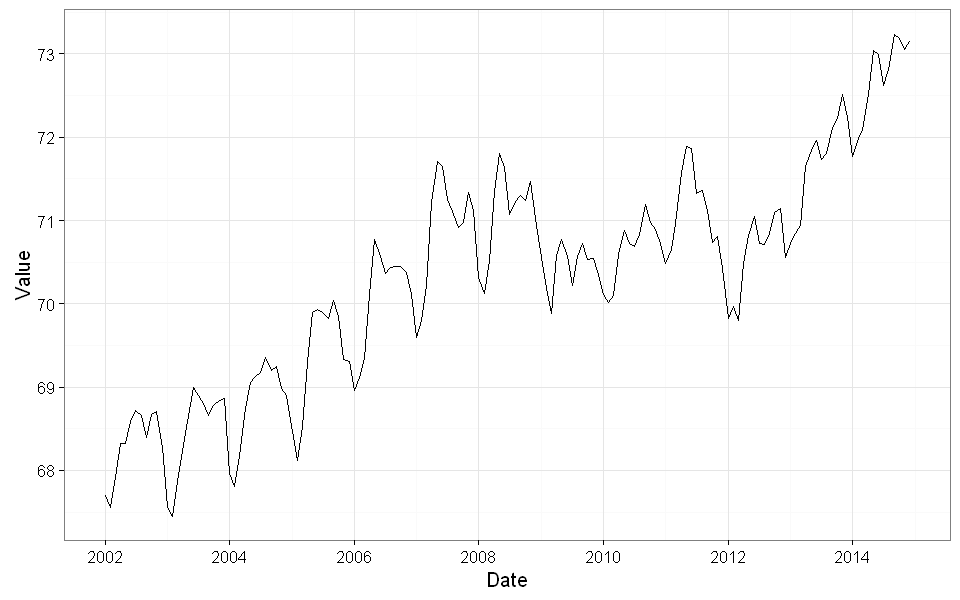

In [192]:
ggplot(jp_data, aes(group = 1)) +
    geom_line(aes(x = Date, y = Value)) +
    theme_bw()

Analyse trend, Linear model


Call:
lm(formula = jp_data$Value ~ index(jp_data))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.67539 -0.44073 -0.04604  0.46465  1.72812 

Coefficients:
                Estimate Std. Error t value            Pr(>|t|)    
(Intercept)    68.301040   0.107830  633.42 <0.0000000000000002 ***
index(jp_data)  0.025812   0.001191   21.66 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6702 on 154 degrees of freedom
Multiple R-squared:  0.7529,	Adjusted R-squared:  0.7513 
F-statistic: 469.3 on 1 and 154 DF,  p-value: < 0.00000000000000022


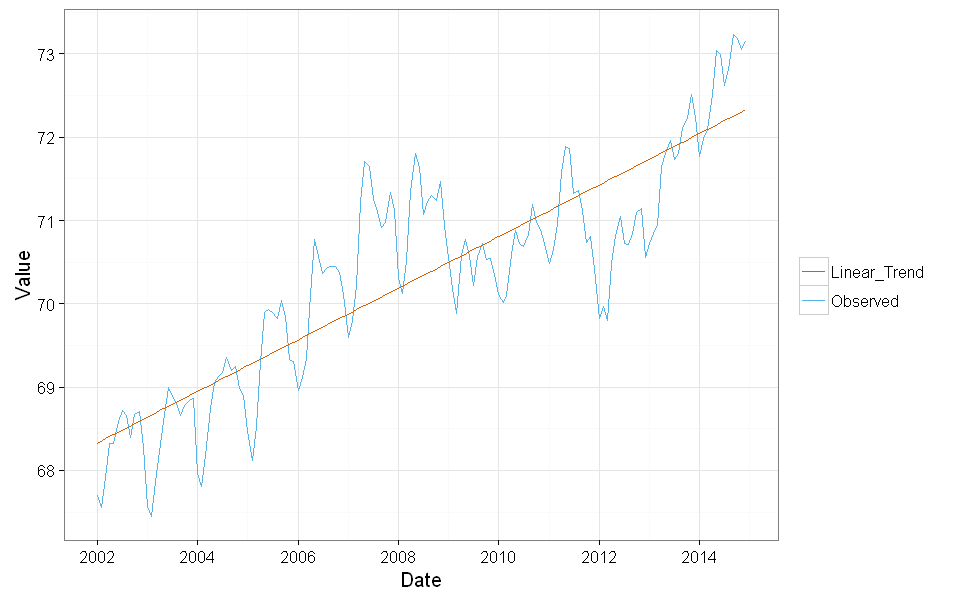

In [193]:
jp_linear_model <- lm(jp_data$Value ~ index(jp_data))
summary(jp_linear_model)
jp_data$Linear_Fit <- jp_linear_model$fitted


ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Linear_Fit, color="Linear_Trend")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Linear_Trend="#D55E00")) +
    theme_bw()



Analyse trend, Polynomial model


Call:
lm(formula = jp_data$Value ~ poly(index(jp_data), 3, raw = TRUE))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.51398 -0.36442  0.00189  0.36611  1.41887 

Coefficients:
                                          Estimate    Std. Error t value
(Intercept)                          67.2432882767  0.1961097800 342.886
poly(index(jp_data), 3, raw = TRUE)1  0.0950256223  0.0107830707   8.812
poly(index(jp_data), 3, raw = TRUE)2 -0.0009982104  0.0001593216  -6.265
poly(index(jp_data), 3, raw = TRUE)3  0.0000039530  0.0000006672   5.925
                                                 Pr(>|t|)    
(Intercept)                          < 0.0000000000000002 ***
poly(index(jp_data), 3, raw = TRUE)1  0.00000000000000262 ***
poly(index(jp_data), 3, raw = TRUE)2  0.00000000364246074 ***
poly(index(jp_data), 3, raw = TRUE)3  0.00000002014017809 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5977 on 152 degrees of freedom
Multipl

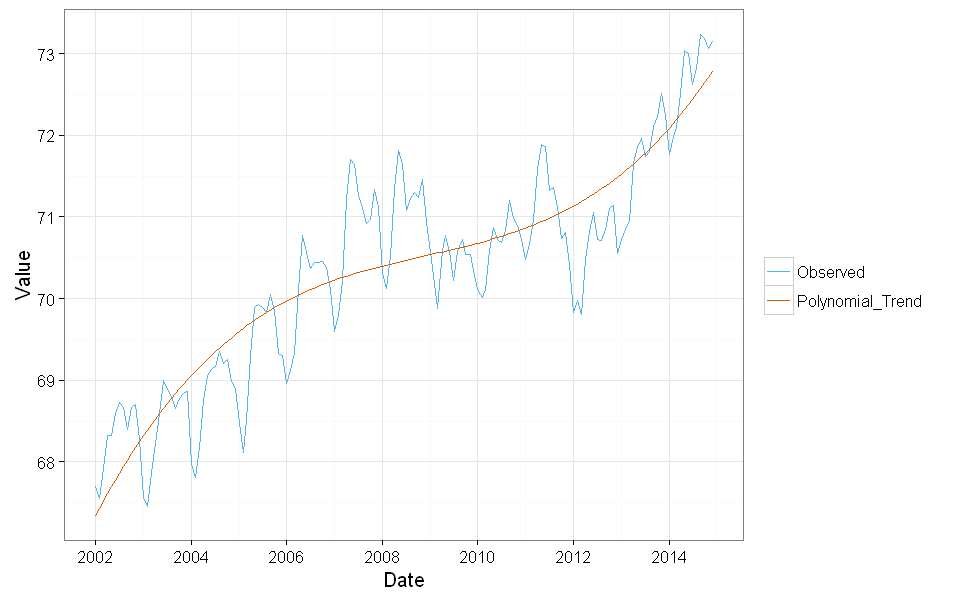

In [194]:
jp_pol_model <- lm(jp_data$Value ~ poly(index(jp_data), 3, raw = TRUE))
summary(jp_pol_model)
jp_data$Pol_Fit <- jp_pol_model$fitted

ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Pol_Fit, color="Polynomial_Trend")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Polynomial_Trend="#D55E00")) +
    theme_bw()


Analyse trend, exponetial smoothing model

Decompose time serie

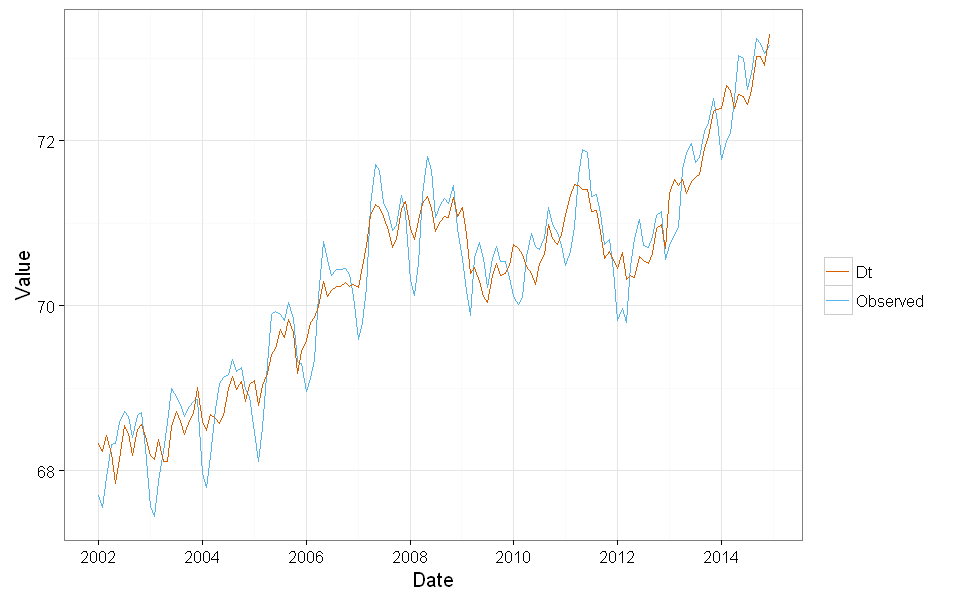

In [195]:
#Calculate moving average
jp_data$Seasonal_Comp <- ma(jp_data$Value, 12)
jp_data$Seasonal_Comp <- ma(jp_data$Seasonal, 4, centre = TRUE)

#Calculate rough seasonal component
jp_data$Seasonal_Comp <- jp_data$Value - jp_data$Seasonal_Comp

temp_monthly_comp <- aggregate(jp_data$Seasonal_Comp ~ jp_data$Month, FUN = mean)
colnames(temp_monthly_comp) <- c("Month", "Seasonal_Comp")

#Calculate how much bigger or smaller the rough component is
fix_ratio <- sum(temp_monthly_comp$Seasonal_Comp) / 12

#Fix the rough seasonal component
temp_monthly_comp$Seasonal_Comp <- temp_monthly_comp$Seasonal_Comp - fix_ratio
jp_data$Seasonal_Comp <- rep(temp_monthly_comp$Seasonal_Comp, 13)

jp_data$Dt <- jp_data$Value - jp_data$Seasonal_Comp

ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Dt, color="Dt")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Dt="#D55E00")) +
    theme_bw()


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(x = jp_data$Dt, h = 24) 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.0001 

  Initial states:
    l = 68.2887 
    b = 0.0309 

  sigma:  0.2044

     AIC     AICc      BIC 
300.4388 300.7037 312.6382 

Error measures:
                      ME      RMSE       MAE          MPE      MAPE      MASE
Training set 0.001201887 0.2044107 0.1672391 0.0009801408 0.2381937 0.9818585
                   ACF1
Training set 0.01233158

Forecasts:
    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
157       73.32473 73.06276 73.58669 72.92409 73.72536
158       73.35566 72.98518 73.72615 72.78905 73.92228
159       73.38660 72.93283 73.84038 72.69261 74.08060
160       73.41754 72.89354 73.94155 72.61615 74.21894
161       73.44848 72.86260 74.03437 72.55245 74.34452
162       73.47942 72.83759 74.12126 72.49782 74.46103
163       73.51036 72.81707 74.20366 72.45006 74.57067
164       73.54130 72.80010 74

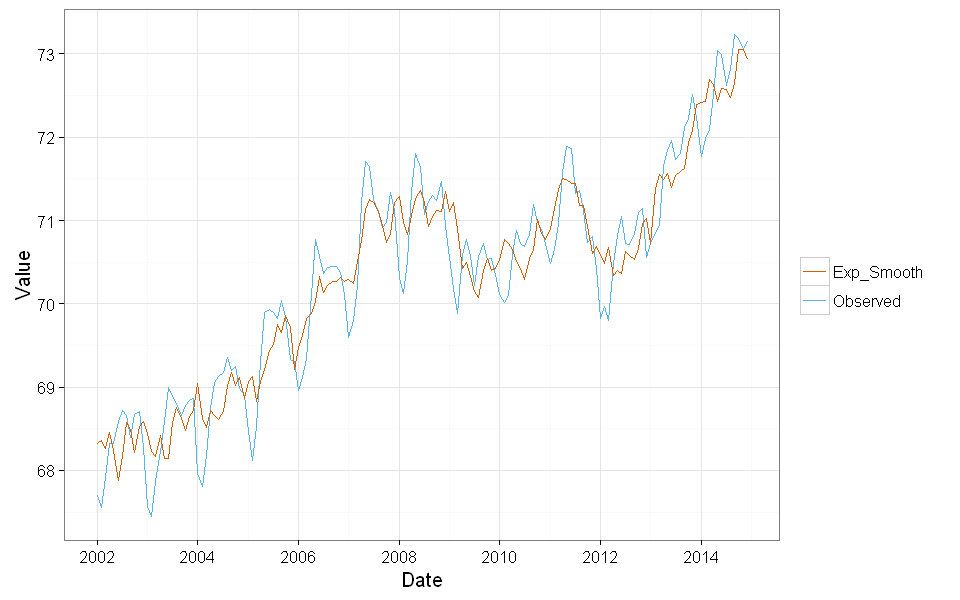

In [196]:
jp_holt_model <- holt(jp_data$Dt, h=24)
summary(jp_holt_model)
jp_data$Holt_Fit <- jp_holt_model$fit

ggplot(jp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Holt_Fit, color="Exp_Smooth")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Exp_Smooth="#D55E00")) +
    theme_bw()

Residual Analysis, Pol

[1] 0.193684

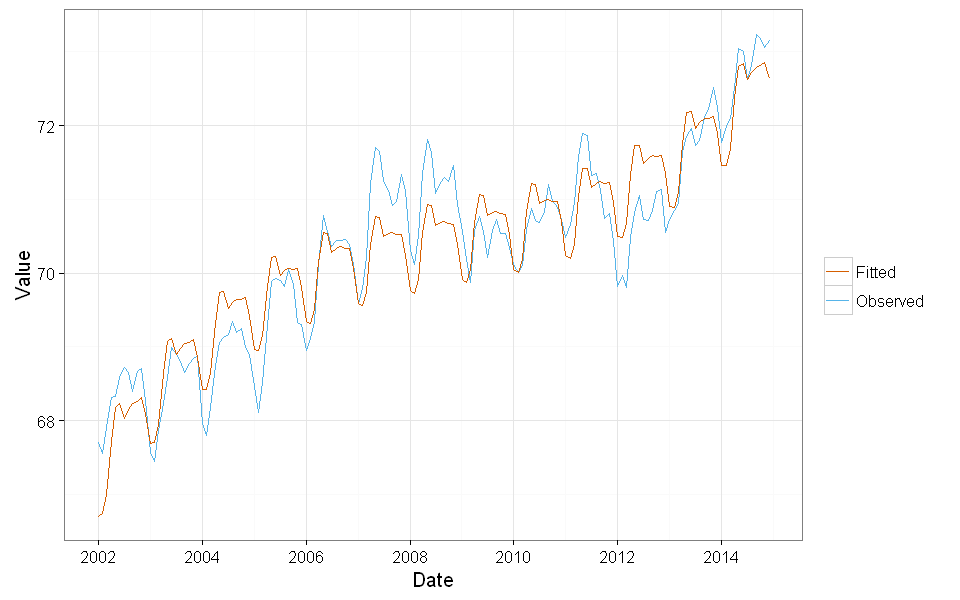

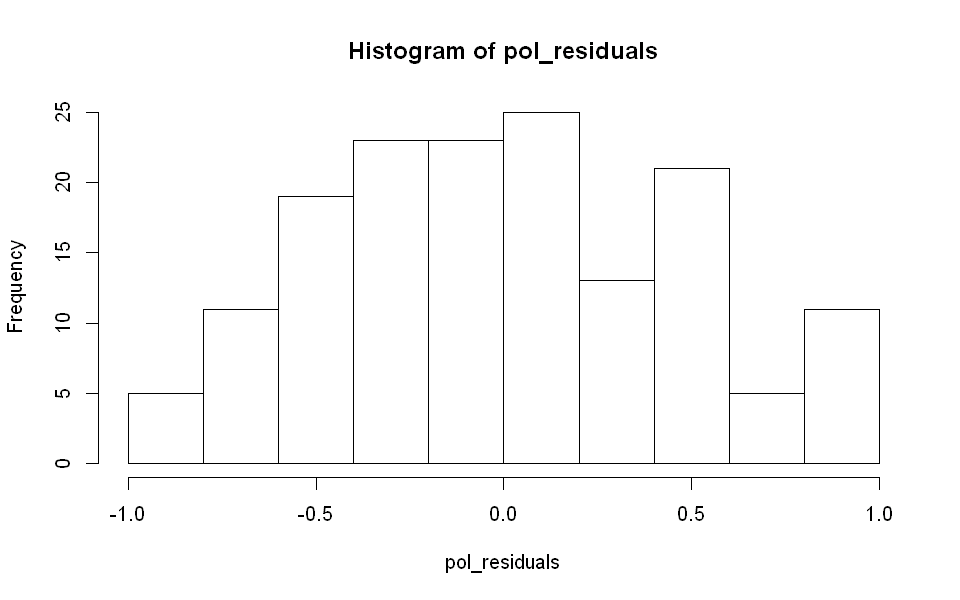

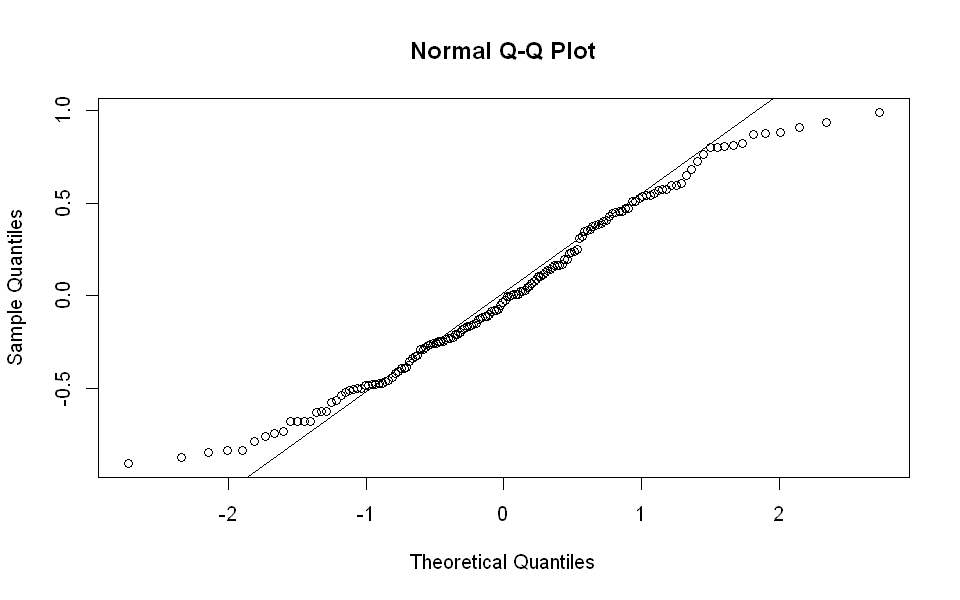

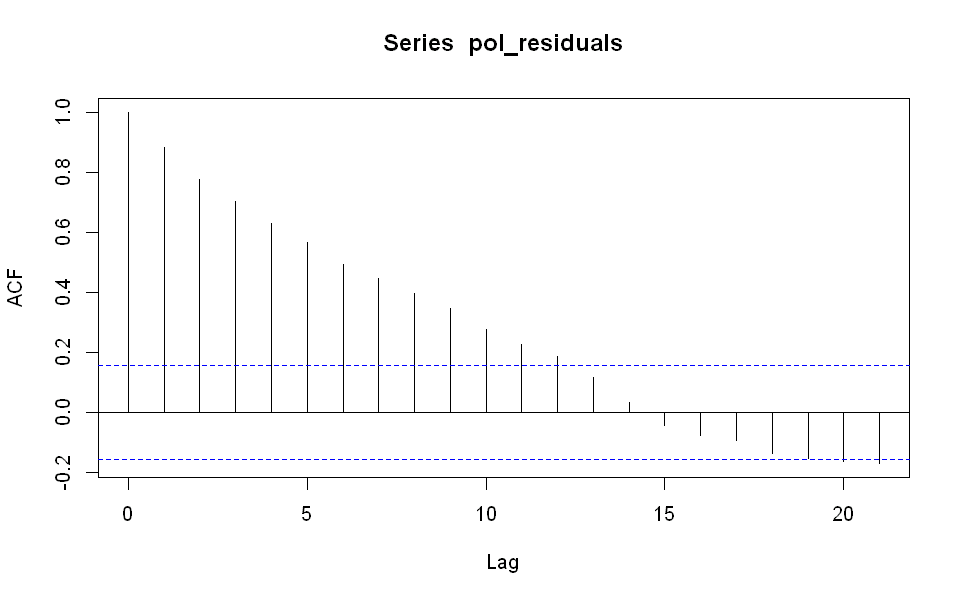

In [197]:
pol_residuals <- jp_data$Value - (jp_data$Pol_Fit + jp_data$Seasonal_Comp)
durbinWatsonTest(pol_residuals)

temp_data <- data.frame(Date = jp_data$Date, Value = jp_data$Value, Fitted = (jp_data$Pol_Fit + jp_data$Seasonal_Comp))
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()

hist(pol_residuals)
qqnorm(pol_residuals)
qqline(pol_residuals)
acf(pol_residuals)

Residual Analysis, Holt

[1] 1.956133

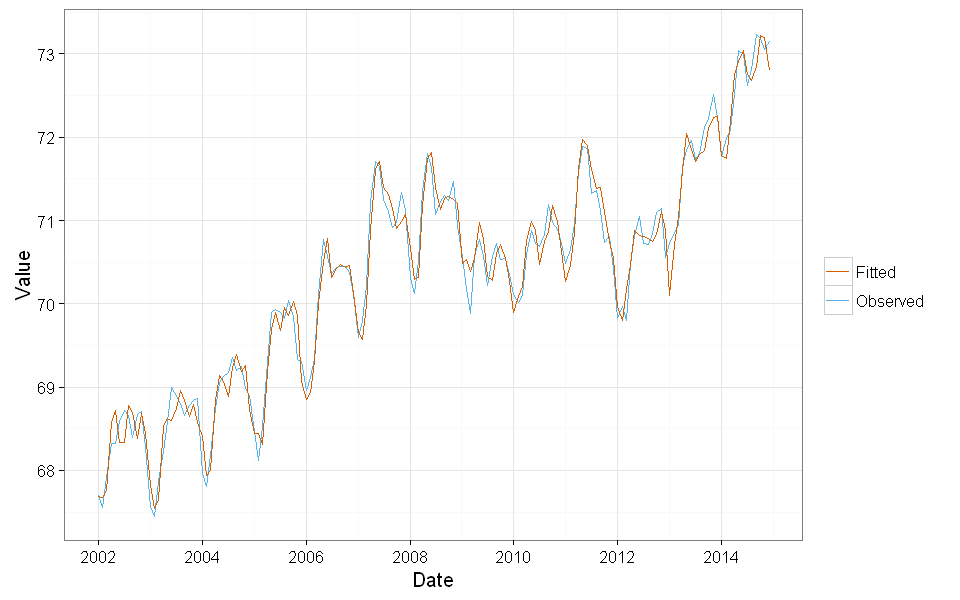

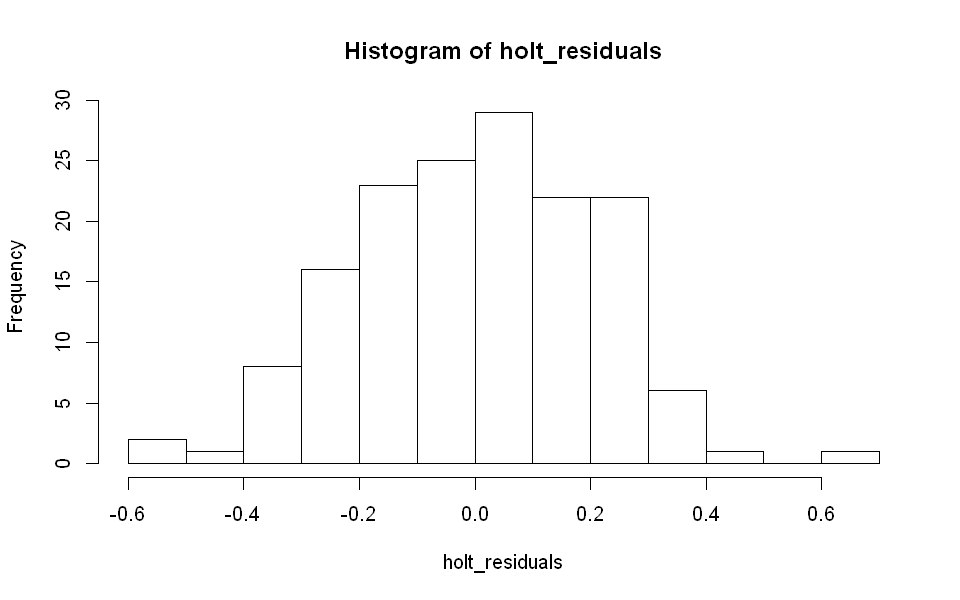

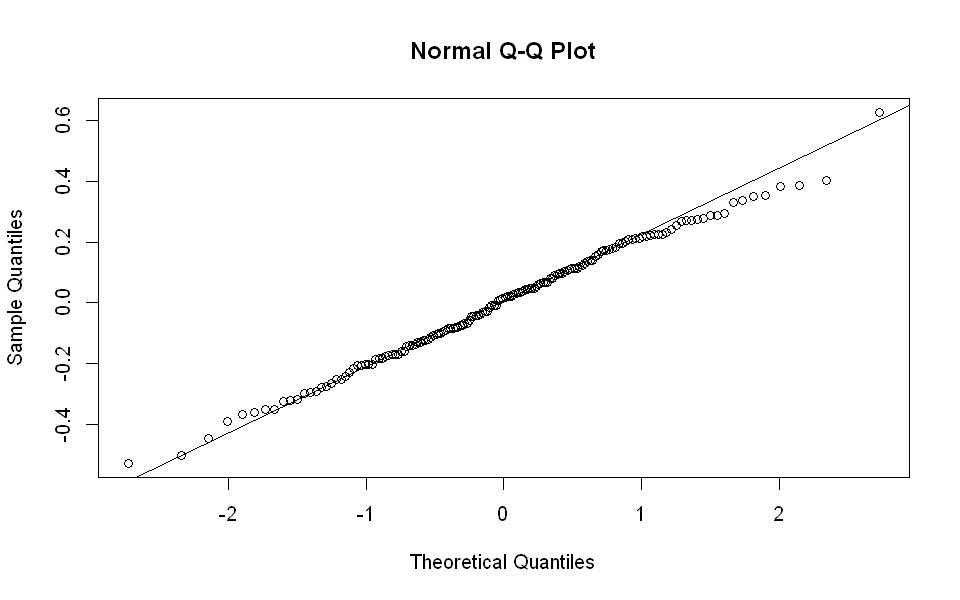

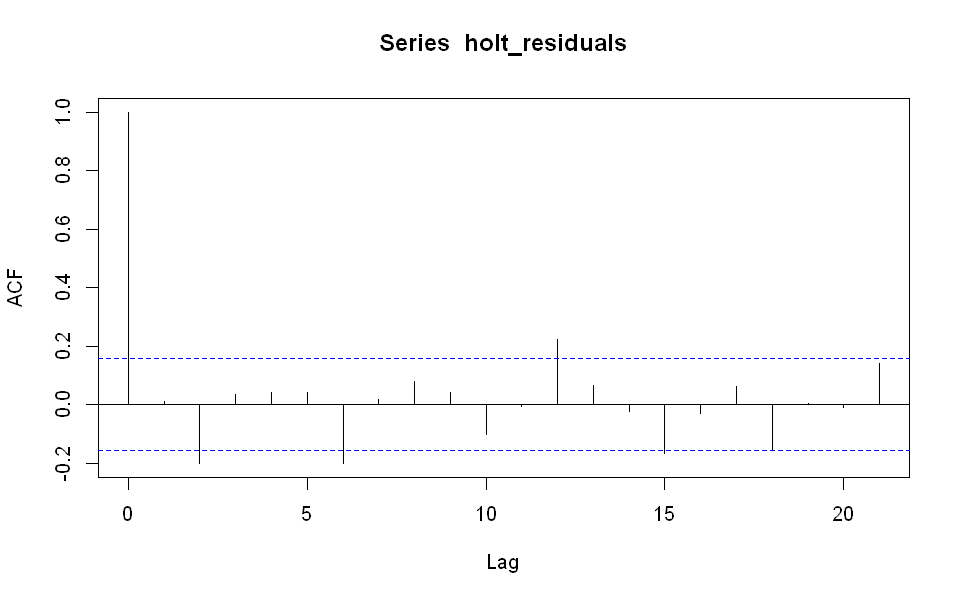

In [198]:
holt_residuals <- jp_data$Value - (jp_data$Holt_Fit + jp_data$Seasonal_Comp)
durbinWatsonTest(as.vector(holt_residuals))

temp_data <- data.frame(Date = jp_data$Date, Value = jp_data$Value, Fitted = (jp_data$Holt_Fit + jp_data$Seasonal_Comp))
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()

hist(holt_residuals)
qqnorm(holt_residuals)
qqline(holt_residuals)
acf(holt_residuals)

Decompose time serie, cycle

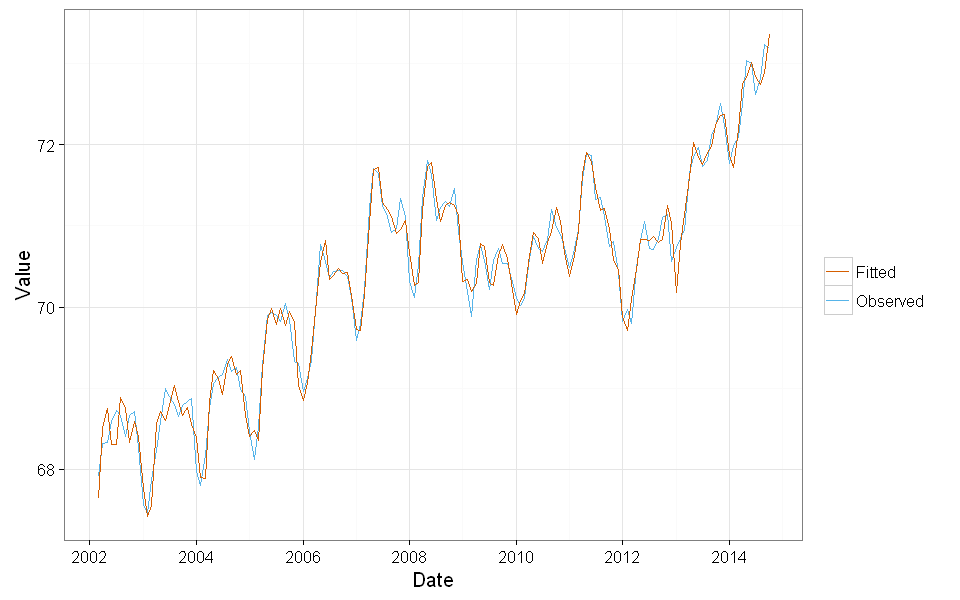

In [199]:
jp_data_shortend <- jp_data
jp_data_shortend$Clir <- jp_data_shortend$Value - (jp_data_shortend$Holt_Fit + jp_data_shortend$Seasonal_Comp)
jp_data_shortend$Cl <- ma(jp_data_shortend$Clir, 5)
jp_data_shortend <- na.omit(jp_data_shortend)
#jp_data_shortend$Ir <- jp_data_shortend$Clir - jp_data_shortend$Cl


#jp_data$Dt <- jp_data$Value - jp_data$Seasonal_Comp

#ggplot(jp_data, aes()) +
#    geom_line(aes(x = Date, y = Value, color="Observed")) +
#    geom_line(aes(x = Date, y = Dt, color="Dt")) +
#    scale_colour_manual(name="", values=c(Observed="#56B4E9", Dt="#D55E00")) +
#    theme_bw()



temp_data <- data.frame(Date = jp_data_shortend$Date,
                        Value = jp_data_shortend$Value,
                        Fitted = (jp_data_shortend$Holt_Fit + 
                                  jp_data_shortend$Seasonal_Comp + 
                                  jp_data_shortend$Cl))
ggplot(temp_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Fitted, color="Fitted")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Fitted="#D55E00")) +
    theme_bw()




[1] 0.2253893

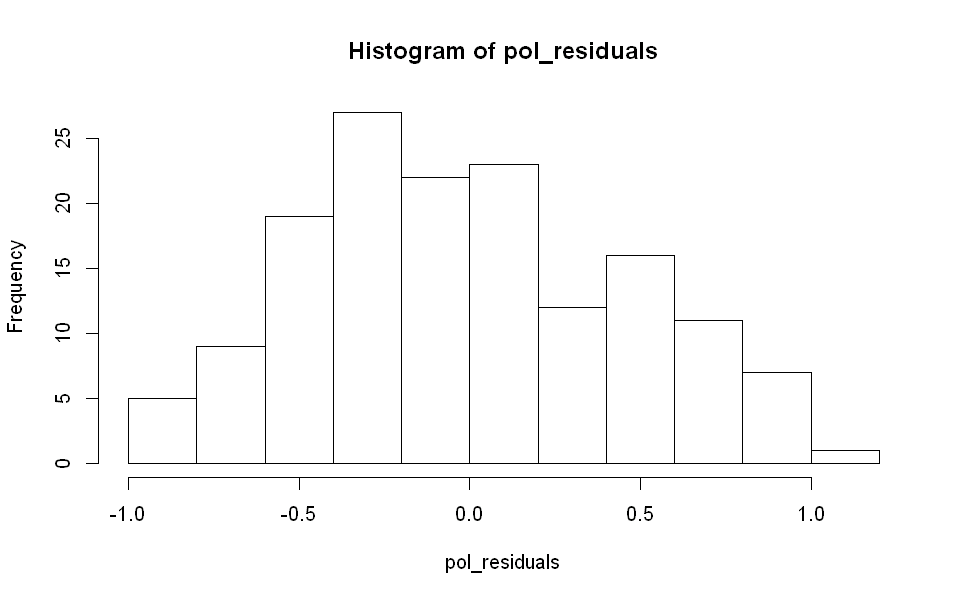

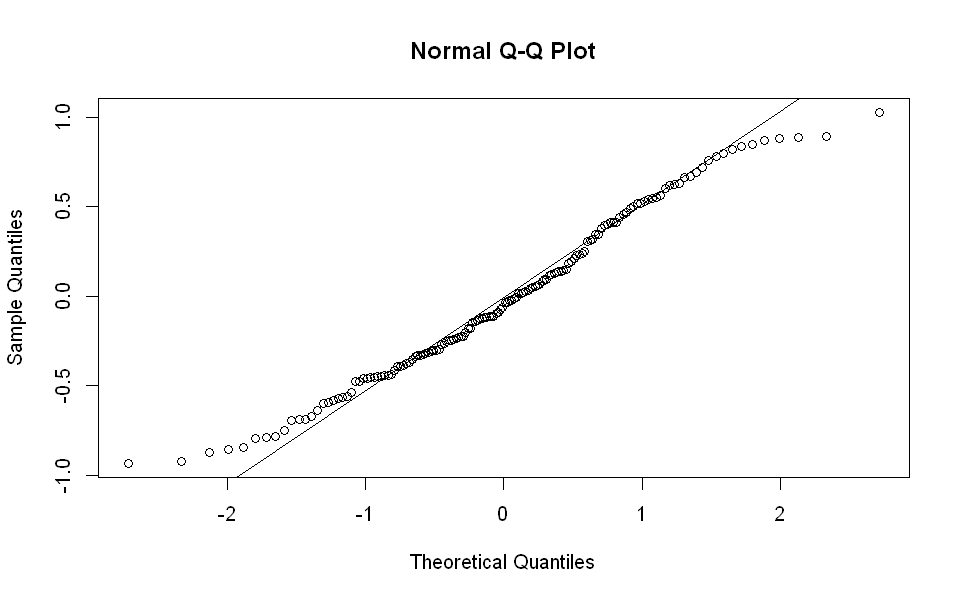

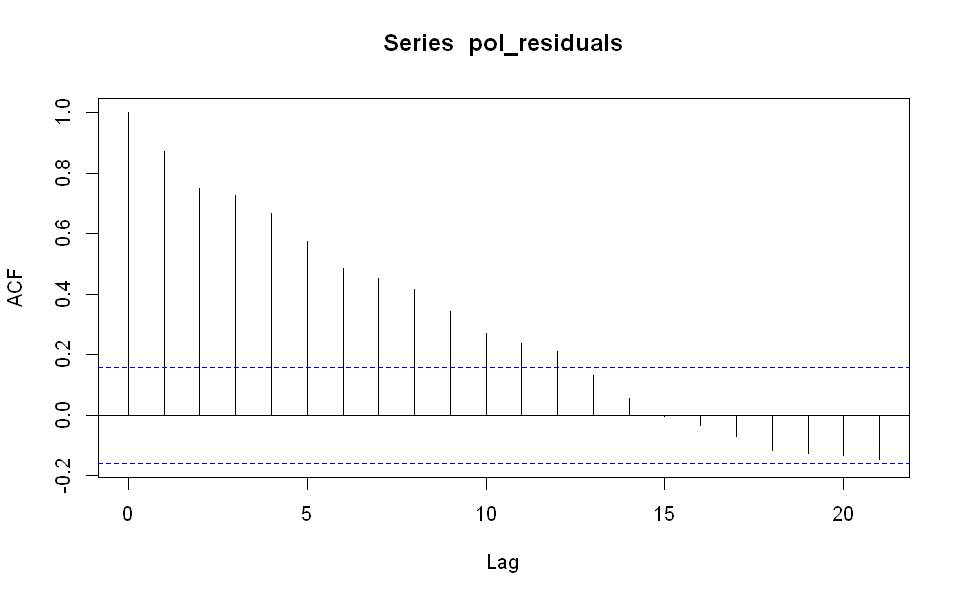

In [200]:
pol_residuals <- jp_data_shortend$Value - (jp_data_shortend$Pol_Fit + 
                                            jp_data_shortend$Seasonal_Comp + 
                                            jp_data_shortend$Cl)
durbinWatsonTest(as.vector(pol_residuals))

hist(pol_residuals)
qqnorm(pol_residuals)
qqline(pol_residuals)
acf(pol_residuals)

[1] 2.41819

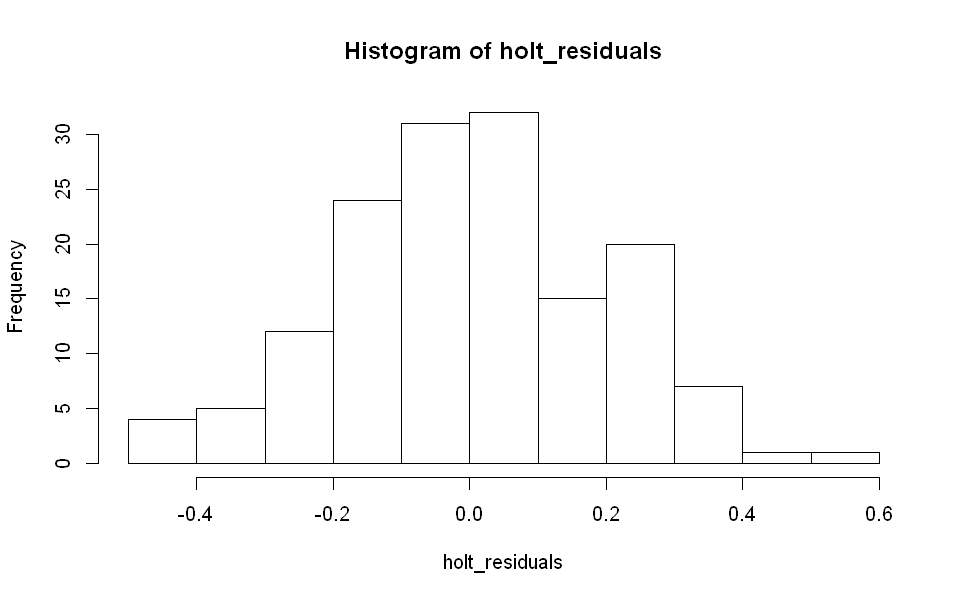

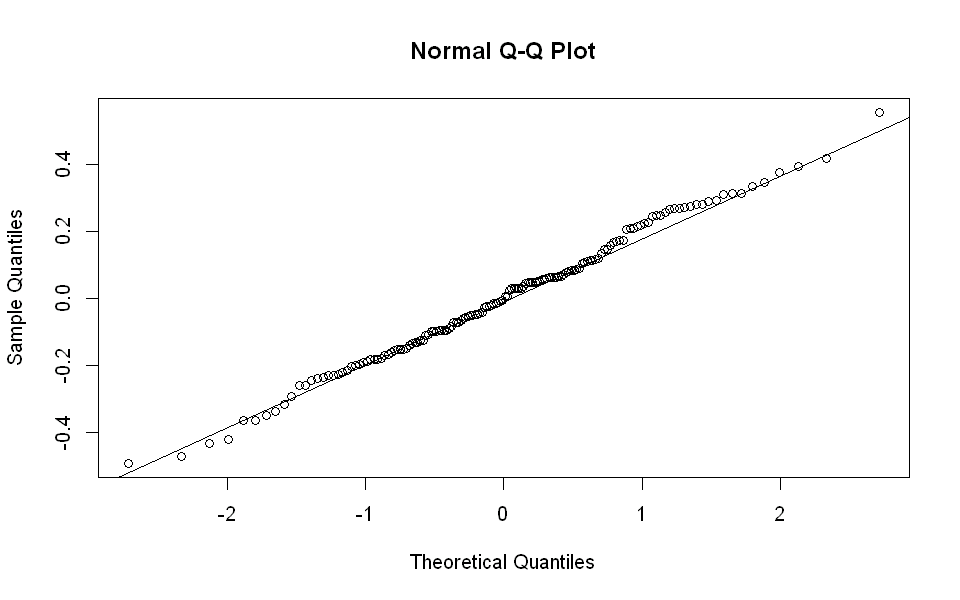

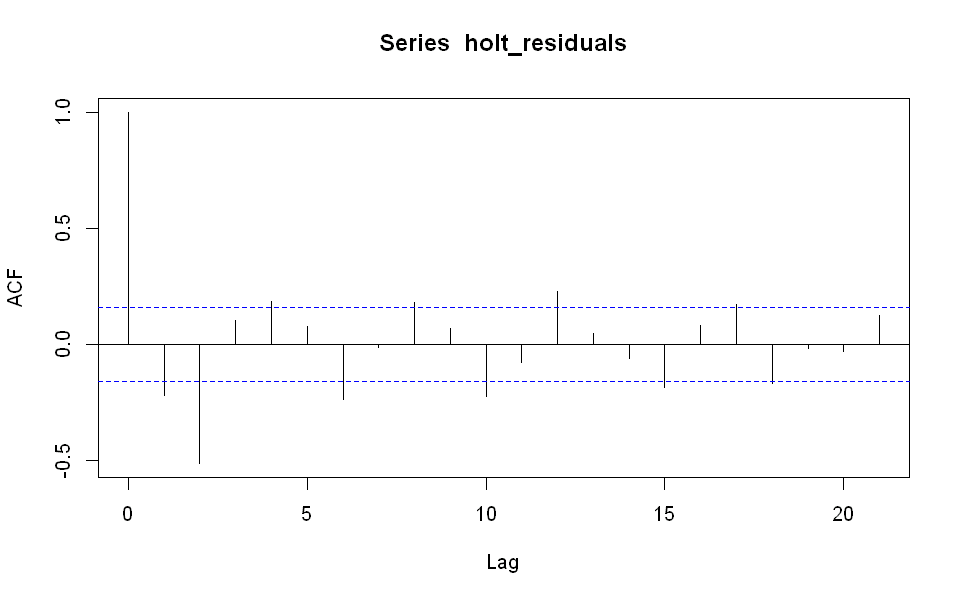

In [201]:
holt_residuals <- jp_data_shortend$Value - (jp_data_shortend$Holt_Fit + 
                                            jp_data_shortend$Seasonal_Comp + 
                                            jp_data_shortend$Cl)
durbinWatsonTest(as.vector(holt_residuals))

hist(holt_residuals)
qqnorm(holt_residuals)
qqline(holt_residuals)
acf(holt_residuals)

Predict

Warning message:
: Removed 24 rows containing missing values (geom_path).

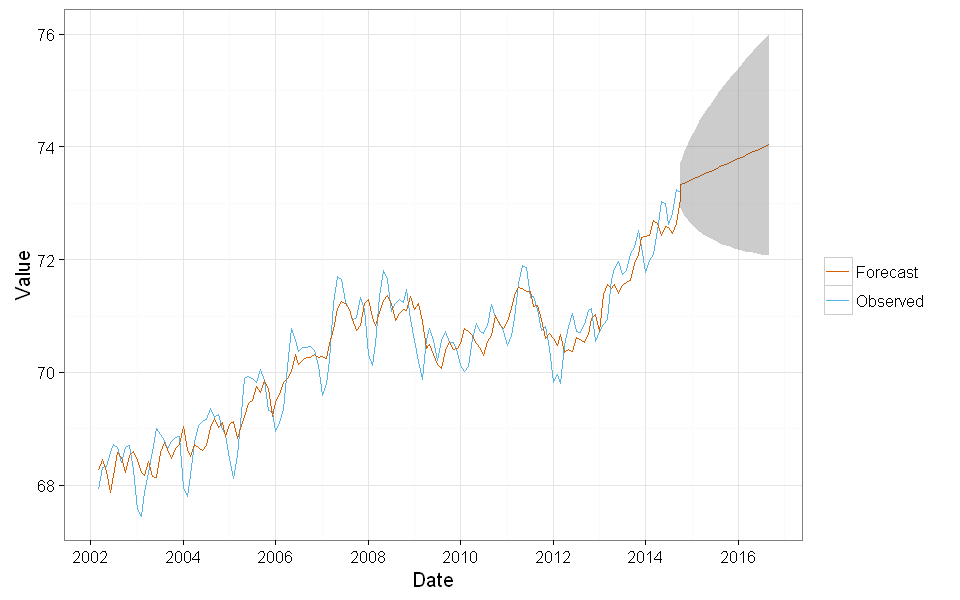

In [202]:
#help(holt)
#jp_holt_model <- holt(jp_data$Value, h=24)
#summary(jp_holt_model)

predict_data <- data.frame(Date = c(jp_data_shortend$Date, seq(as.Date("2014-10-01"), by = "month", length.out = 24)),
                        Value = c(jp_data_shortend$Value, rep(NA, 24)),
                        Forecast = c(jp_data_shortend$Holt_Fit, jp_holt_model$mean),
                        Forecast_low = c(jp_data_shortend$Holt_Fit, jp_holt_model$lower[,2]),
                        Forecast_high = c(jp_data_shortend$Holt_Fit, jp_holt_model$upper[,2]))
#predict_data

ggplot(predict_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Forecast, color="Forecast")) +
    geom_ribbon(aes(x = Date, ymin=Forecast_low, ymax=Forecast_high), alpha=.25) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Forecast="#D55E00")) +
    theme_bw()
